# Labor zu simulationsbasierter Inferenz

Literatur: 
- Sauer Moderne Datenanalyse mit R, Kapitel 17.3 und 17.4 (evtl. weitere Abschnitte aus Kapitel 16 und 17)
- Bruce et al. Praktische Statistik für Data Scientists, Auszüge aus Kapitel 2 und 3
- Python-Dokumentationen

Sie werden hier:
- per Bootstrapping Stichprobenverteilungen erstellen
- aus einer Stichprobenverteilung ein Konfidenzintervall bestimmen
- anhand einer Stichprobenverteilung eine Hypothese testen

Lernziele:
- wissen, was man unter Bootstrapping versteht
- den Unterschied zwischen einer Bootstrap-Stichprobenverteilung und einer 'normalen' Verteilung erläutern können
- einfache Simulationskonzepte anwenden können, 
    - um Konfidenzintervalle zu bestimmen
    - um inferenzstatistische Schlüsse zu ziehen
- den p-Wert im Rahmen von Simulationskonzepten interpretieren können
- Nullhypothesen für einfache Fragestellungen mit Simulationskonzepten testen können

Output:
- Durchführung einer (einfachen) Inferenzanalyse zum Flugdatensatz

In [1]:
# Nötige Module importieren
import pandas as pd

# Plotten
import matplotlib.pyplot as plt
import seaborn

# Zum (einfacheren) Erstellen guter statistischer Plots:
import seaborn as sns

seaborn.set_theme()  # alle Plots (auch von matplotlib) im seaborn-Style

# Numerische und statistisches Operationen
import numpy as np
from scipy import stats
from sklearn.utils import resample

## 1. Bootstrapping

In Realität haben wir nur eine Stichprobe. Wie bekommen wir eine Stichprobenverteilung und damit einen Standardfehler, um von unseren Stichprobenkennwerten auf die Populationskennwerte zu schließen?

Bootstrapping ist eine Möglichkeit, die Stichprobenverteilung zu schätzen. Dabei wird aus der Stichprobe mit Zurücklegen gezogen. Die Stichprobe wird also mehrfach gezogen, wobei jedes Element der Stichprobe mit der gleichen Wahrscheinlichkeit gezogen wird. Die Stichprobenverteilung wird dann aus den gezogenen Stichproben berechnet. Dieses Prinzip nennt man Resampling und es wird sehr häufig (und auch schon relativ lange) erfolgreich angewendet (Die Konfidenzintervalle des Medians bei Boxplots werden z.B. damit bestimmt). Wir werden Bootstrapping nun nutzen und uns anschauen, was wir daran lernen können und was wir bei Verwendung beachten müssen.

Wir nutzen hierfür wieder die flights-Daten und führen folgende Schritte durch:
- Ziehen einer Stichprobe (das ist jetzt die einzige echte Stichprobe, die wir im Folgenden nutzen!)
- Erzeugen von bootstrap-Samples aus dieser Stichprobe
- Betrachten der Bootstrap-Verteilung der Mittelwerte aller Bootstrap-Samples

In [2]:
# load data
from nycflights13 import flights

fls = flights.dropna()
delay = fls['arr_delay']
print(delay.mean())
np.random.seed(
    seed=3)  # es werden bei Wiederholung immer die gleichen Daten gezogen (Reproduzierbarkeit des code-Beispiels!)

# create a sample of 5 arrival delays
sample5 = resample(delay, n_samples=5, replace=False)
print(sample5)
print(sample5.mean())

6.89537675731489
112924    -16.0
96688      23.0
154059      1.0
197977    124.0
279946    -19.0
Name: arr_delay, dtype: float64
22.6


Hier haben wir nun eine echte Stichprobe gezogen. Nun ziehen wir daraus eine Bootstrap Stichprobe:

In [3]:
bootstrap_sample = resample(sample5)  #per default wird mit Zurücklegen gezogen, also replace=True
print(bootstrap_sample)

279946   -19.0
279946   -19.0
112924   -16.0
112924   -16.0
112924   -16.0
Name: arr_delay, dtype: float64


Hier sieht man nun, dass durch Ziehen mit Zurücklegen gezogen wurde und damit einige Werte nun doppelt auftreten.

Wir machen das Ganze nun mit einer größeren Stichprobe (30 Werte) und ziehen daraus 1000 Bootstrap-Stichproben. Wir schauen uns dann die Verteilung der Mittelwerte an.


In [4]:
np.random.seed(123)
# Ziehen der echten Stichprobe:
echte_stichprobe = resample(delay, n_samples=30, replace=False)

# 1000 Bootstrap-Stichproben ziehen und Mittelwert und Median berechnen:
results_mean = []
results_median = []
for _ in range(1000):
    sample = resample(echte_stichprobe)  #Standardeinstellung: resample=True
    results_mean.append(sample.mean())
    results_median.append(sample.median())
results_mean = pd.Series(results_mean)
results_median = pd.Series(results_median)

c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


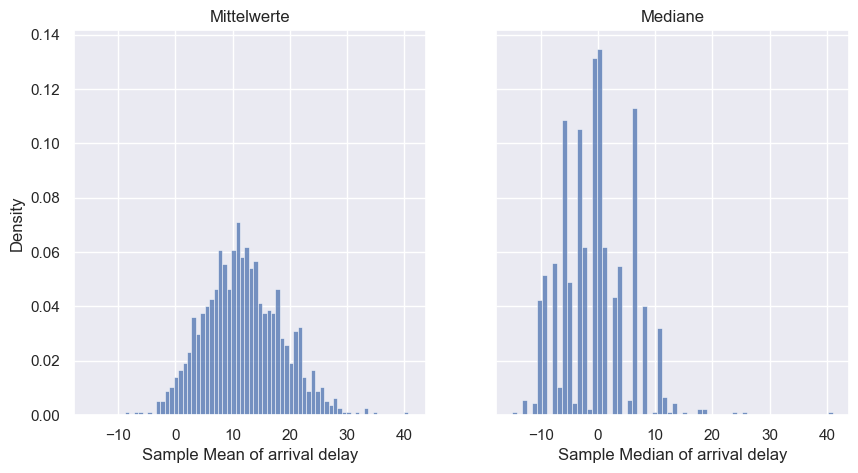

Mittelwert = 11.849033333333333
Standardfehler = 6.816227208085212


In [5]:
# plot Histogram der Mittelwerte und Mediane mit gleichen Achsen:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
sns.histplot(results_mean, bins=64, stat='density', ax=axs[0])
sns.histplot(results_median, bins=64, stat='density', ax=axs[1])
axs[0].set_title('Mittelwerte')
axs[1].set_title('Mediane')
axs[0].set_xlabel('Sample Mean of arrival delay')
axs[1].set_xlabel('Sample Median of arrival delay')
plt.show()
print('Mittelwert =', results_mean.mean())
print('Standardfehler =', results_mean.std())

Passen die Histogramme und die berechneten Parameter zu dem, was Sie erwarten (also zum letzten Labor)? Woher kommen Unterschiede?

--> Standardfehler aus dem letzten Labor zwischen 4 und 8 passt zum Standardfehler von 6. Form nicht ganz so normalverteilt wie asu der Gesamtheit.

## 2. Konfidenzintervalle

### 2.1 Konfidenzintervall für den Mittelwert

Im Folgenden wollen wir das 95%-Konfidenzintervall für den Mittelwert bestimmen. Als Konfidenzintervall hätten wir gerne einen Bereich, in dem der Mittelwert mit einer Wahrscheinlichkeit von 95% liegt. Dazu schauen wir uns die Verteilung der Mittelwerte an und bestimmen die Werte, die bei 2,5% und 97,5% liegen. Das sind dann die Grenzen des Konfidenzintervalls. Wirklich korrekt ist diese Definition eines Konfidenzintervalls nicht $\rightarrow$ das diskutieren wir in der Vorlesung.


95%-Konfidenzintervall der Bootstrap-Verteilung:[ -0.40 ; 25.44]


c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


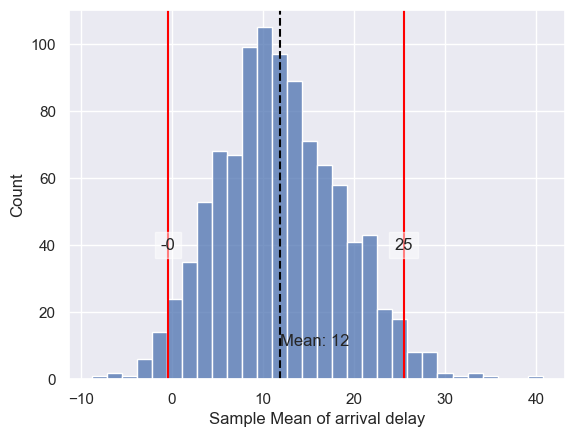

In [6]:
# Berechnung der 2,5% and 97,5% Perzentile der Bootstrap-Verteilung
conf_int = results_mean.quantile([0.025, 0.975])
print(f"95%-Konfidenzintervall der Bootstrap-Verteilung:[ {conf_int.iloc[0]:.2f} ; {conf_int.iloc[1]:.2f}]")

# Histogramm der Bootstrap-Verteilung mit Darstellung des Konfidenzintervalls
fig, axs = plt.subplots(1, 1)
sns.histplot(results_mean, bins=30)
plt.axvline(conf_int.iloc[0], color='red')
plt.axvline(conf_int.iloc[1], color='red')
plt.axvline(results_mean.mean(), color='black', linestyle='--')
axs.text(conf_int.iloc[0], 40, f'{conf_int.iloc[0]:.0f}',
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
         horizontalalignment='center', verticalalignment='center')
axs.text(conf_int.iloc[1], 40, f'{conf_int.iloc[1]:.0f}',
         bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
         horizontalalignment='center', verticalalignment='center')
axs.text(results_mean.mean(), 10, f'Mean: {results_mean.mean():.0f}')
axs.set_xlabel('Sample Mean of arrival delay')
plt.show()

### 2.2 Konfidenzintervall für den Median


In [7]:
#TODO: Konfidenzintervall für den Median bestimmen und interpretieren
conf_int = results_median.quantile([0.025, 0.975])
print(f"Konfidenzintervall des Medians:[ {conf_int.iloc[0]:.2f} ; {conf_int.iloc[1]:.2f}]")


Konfidenzintervall des Medians:[ -10.00 ; 11.00]


## 3. Statistische Tests
(Siehe Sauer Kapitel 17.4)

Häufig möchte man Entscheidungen treffen, zum Beispiel: Ist die mittlere Verspätung größer als 5 Minuten (das könnte man sich bei der Deutschen Bahn manchmal fragen...)?

Solche Entscheidungen können wir nur mit Sicherheit treffen, wenn wir die Grundgesamtheit kennen - also alle Daten. Das ist im Normalfall nicht so und wir müssen aus unserer Stichprobe schätzen. Eine (ziemlich gute) Möglichkeit ist eine Stichprobenverteilung für den gesuchten Parameter zu bestimmen und daraus wie oben das Konfidenzintervall zu berechnen. Dann könnten wir schauen, ob die Verspätung im Konfidenzintervall enthalten ist. In der Praxis wird allerdings häufig eine andere Stichprobenverteilung erstellt, nämlich die Stichprobenverteilung der Testgröße des passenden statistischen Tests.
Versuchen Sie das anhand von Sauer, Kapitel 17.4 mit dem Flugdatensatz durchzuführen!

Ein Hinweis: Das beschriebene Vorgehen konstruiert die Stichprobenverteilung der Einfachheit halber aus normalverteilten Daten. Simulationsbasierte Tests ohne Verteilungsannahme sind in Form von Permutationstests sehr nützlich. Das schauen wir uns später an, hier soll es zunächst um die Grundidee des statistischen Testens gehen.

Die Codebeispiele im Buch sind in R programmiert. Hier ein paar Codeschnipsel zum Vorgehen in python:

In [8]:
# TODO: Durchführen eines statistischen Tests analog zu Sauer Kapitel 17.4

11.6


c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

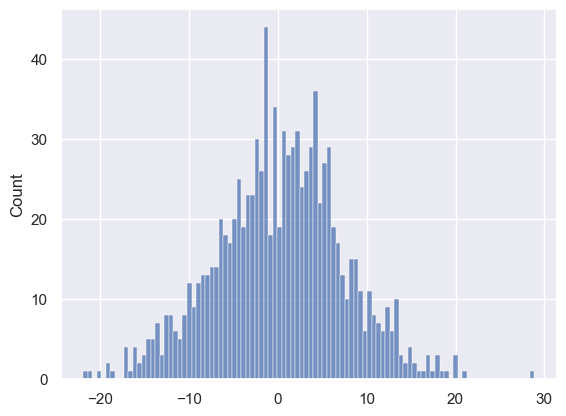

In [9]:
'''Aufstellen der Hypothesen:
H1: Mittelwert != 0
H0: Mittelwert = 0
'''

'''Wir brauchen nun eine Aussage über die H0, da wir ja annehmen, dass die H0 wahr ist und wir wollen unsere Stichprobe dann mit der H0 vergleichen. Wir kreieren uns daher eine Stichprobenverteilung aus der H0. Hierzu nehmen wir an, dass die H0 normalverteilt ist mit Erwartungswert 0 und als Streuung nutzen wir die Streuung unserer Stichprobe. 
'''
np.random.seed(123)
tests_mean = []
print(np.mean(echte_stichprobe))
# Schleife mit 1000 Wiederholungen:
for _ in range(1000):
    # Ziehen einer Stichprobe von 30 Werten aus Normalverteilung mit Erwartungswert 0 (loc=...) und Streuung der Stichprobe (scale=...)
    sample = np.random.normal(loc=0, scale=echte_stichprobe.std(), size=30)

    # Mittelwert der Stichprobe berechnen und in Liste einfügen
    tests_mean.append(sample.mean())
    
# Histogramm der Liste darstellen
sns.histplot(tests_mean,bins=100)

In [10]:
# Berechnung des p-Werts der echten Stichprobe. 
# p-Wert = wie wahrscheinlich wäre der echte Stichprobenmittelwert oder ein extremerer Wert, wenn die H0 wahr wäre?
# Berechnet werden muss also der Anteil der Werte in der Stichprobenverteilung, die größer oder gleich dem echten Stichprobenmittelwert sind.

counter = 0
echte_stichprobe_mean = np.mean(echte_stichprobe)

for value in tests_mean:
    if abs(value) >= echte_stichprobe_mean:
        counter += 1

print(f"Der p-Wert beträgt: {counter/np.size(tests_mean)}")



Der p-Wert beträgt: 0.115


c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Der p-Wert beträgt: 0.0


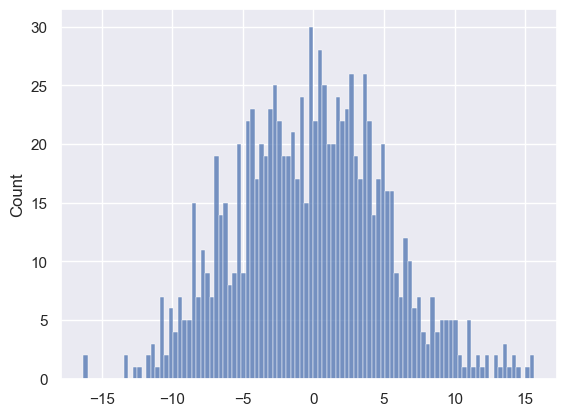

In [11]:
# TODO: Wiederholen Sie das Ganze mit einer Stichprobe von 100 Werten und verschiedenen sample seeds (z.B. 3 und 38)

np.random.seed(38)
# Ziehen der echten Stichprobe:
echte_stichprobe_100 = resample(delay, n_samples=100, replace=False)

tests_mean_100 = []
# Schleife mit 1000 Wiederholungen:
for _ in range(1000):
    # Ziehen einer Stichprobe von 100 Werten aus Normalverteilung mit Erwartungswert 0 (loc=...) und Streuung der Stichprobe (scale=...)
    sample = np.random.normal(loc=0, scale=echte_stichprobe_100.std(), size=100)

    # Mittelwert der Stichprobe berechnen und in Liste einfügen
    tests_mean_100.append(sample.mean())
    
# Histogramm der Liste darstellen
sns.histplot(tests_mean_100,bins=100)

counter = 0
echte_stichprobe_mean_100 = np.mean(echte_stichprobe_100)

for value in tests_mean_100:
    if abs(value) >= echte_stichprobe_mean_100:
        counter += 1

print(f"Der p-Wert beträgt: {counter/np.size(tests_mean_100)}")

## 4. Anwendung auf den Flights-Datensatz

Überlegen Sie sich eine (einfache) Fragestellung zum Flugdatensatz, die Sie gerne mit statistischer Inferenz beantworten würden. 
Beschränken Sie sich zunächst auf eine einfache Fragestellung wie
- Wie groß ist das 95%-Konfidenzintervall für den Mittelwert der Verspätung bei Ankunft bei Flügen aus Hawai?
- Entspricht der Mittelwert/Median einem bestimmten Wert? (z.B. distance bei Abflug von JFK)
- etc.
(Bleiben Sie bei den Tests bei einer einfachen Fragestellung, die einen Aspekt mit einem festen Wert oder 0 vergleicht. Zum Vergleich verschiedener Werte, z.B. "Sind Flüge von United Airlines stärker verspätet als Flüge von Delta Airlines?" nutzt man simulationstechnisch Permutationstests. Diese werden wir später anschauen.)

Nutzen Sie für Ihre Analyse eine Stichprobe von 100 Werten aus dem Flugdatensatz. Ihr Ergebnis vergleichen Sie dann zur Kontrolle mit den echten Daten, also dem Wert des gesamten Datensatzes. Wählen Sie für Ihre Analyse eine der folgenden Alternativen:

#### Alternative 1: Simulationsbasierte Berechnung eines Konfidenzintervalls
Gehen Sie vor wie in Abschnitt 2.

#### Alternative 2: Simulationsbasierter statistischer Test
Stellen Sie die passenden Hypothesen auf und gehen Sie vor wie in Abschnitt 3.


In [12]:
# ToDo: Fragestellung zum flight-Datensatz überlegen, die Sie mit statistischer Inferenz beantworten wollen würden und mit einer Stichprobe von 100 Werten anhand einer der zwei Alternativen beantworten

# Alternative 2

'Fragestellung: Beträgt die Abflugverspätung am Flughafen JFK im Mittel 0 Minuten? '
'H0: Mittelwert = 0'
'H1: Mittelwert != 0'
from nycflights13 import flights

data = flights.dropna()

fls = []

for _, row in data.iterrows():
    if row['origin'] == 'JFK':
        fls.append(row['dep_delay'])
        



17.65


c:\Users\pawel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Der p-Wert beträgt: 0.014
12.02


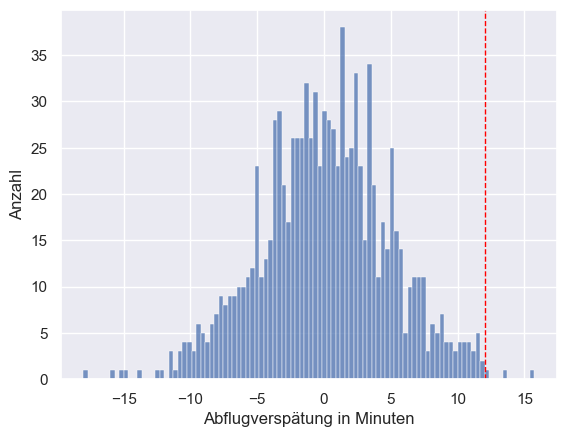

In [13]:
np.random.seed(52)
stichprobe = resample(fls,n_samples=100,replace=False)
print(np.mean(stichprobe))
test_flights_mean = []

for _ in range(1000):
    sample = np.random.normal(loc=0, scale=np.std(stichprobe), size=100)

    test_flights_mean.append(sample.mean())

sns.histplot(test_flights_mean,bins=100)
plt.axvline(np.mean(fls), color='red', linestyle='dashed', linewidth=1, label='Mittelwert der echten Stichprobe')
plt.xlabel("Abflugverspätung in Minuten")
plt.ylabel("Anzahl")

counter = 0
echte_stichprobe_mean_100 = np.mean(stichprobe)

for value in test_flights_mean:
    if abs(value) >= echte_stichprobe_mean:
        counter += 1

print(f"Der p-Wert beträgt: {counter/np.size(test_flights_mean)}")
print(f"{np.mean(fls):.2f}")



### Output: Übersicht über die von Ihnen durchgeführte Analyse

Laden Sie eine Übersicht Ihrer Analyse auf moodle hoch (Umfang: 1-2 Powerpoint Folien oder 1 Seite pdf). Die Übersicht sollte folgende Informationen enthalten:
- Fragestellung (bei einem Test incl. Hypothesen)
- Graph der Bootstrap-Verteilung mit Markierung des Konfidenzintervalls bzw. bei einem Test des echten Werts
- Ihre Interpretation/Schlussfolgerung des Konfidenzintervalls/Tests
- Vergleich mit echtem Wert

In [14]:
# ToDo: Übersicht der vorigen Analyse erstellen und auf moodle hochladen

## Reflexion: Interpretation von Konfidenzintervallen und statistischen Tests
Die Berechnung von Konfidenzintervallen und statistischen Test programmiert man selten selbst, die korrekte Interpretation sollte man aber beherrschen.
Überlegen Sie daher noch einmal, was Sie durch den simulationsbasierten Ansatz gelernt haben und ob Sie folgende Fragen beantworten können: 
- Wofür kann man Bootstrapping nutzen?
- Was ist der Unterschied zwischen der Entscheidung anhand eines Konfidenzintervalls und der Entscheidung basierend auf einem statistischen Test? 
- Wie häufig tritt eine Fehlentscheidung auf?
- Welchen Zusammenhang gibt es zwischen Nullhypothese, Signifikanzniveau und möglichen Fehlentscheidungen?

Kontrollfragen zum Verständnis dieser und ähnlicher Fragen bringe ich in die nächste Vorlesung mit. Offene Fragen Ihrerseits könenn Sie mir auch gerne im Voraus schicken.